In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import matplotlib.colors as mcolors 
import datetime                   # library for date manipulation

from scipy.stats import norm, pearsonr

from sklearn.linear_model import MultiTaskLassoCV
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

from os import path
import sys
sys.path.append("../src/confer_wp3/")
from confer_wp3.dataloading import load_raw_data, save_anomalies, save_eofs_pcs
from confer_wp3.validation import validate_anomalies1, validate_anomalies2, validate_anomalies3, validate_anomalies4, validate_eofs, validate_pcs, validate_indices
from confer_wp3.lasso_forecast import calculate_anomalies, compute_eofs_pcs, quantile_mapping, get_all_indices

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loading, and save out.

### CHIRPS Data

##### Loading data

In [4]:
# Temporary directory for storing results
val_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/"

# Load data
year, lat, lon, prec_data = load_raw_data(chirps_dir, "chirps", [*range(year_train_start, year_train_end+1)], season, lat_bnds, lon_bnds) # 1993, 2021
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Loaded data shape: (40, 67, 59)
NaN values in loaded data: 76200


##### Get/calculate anomalies and normalized anomalies

In [5]:
# Get anomalies
if not path.exists(f'{val_dir}chirps_anomalies.nc'):
    # Calculate anomalies
    anomalies = calculate_anomalies(prec_data, year, period_clm)
    # Save anomalies
    save_anomalies(anomalies, year, lat, lon, val_dir, normalized=False)
else:
    anomalies = xr.open_dataarray(f'{val_dir}chirps_anomalies.nc', engine='netcdf4')
    anomalies = anomalies.values
print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(40, 67, 59)
(40, 67, 59)
NaN values in prec_data: 76200
NaN values in anomalies: 76200


In [6]:
# Get normalized anomalies
if not path.exists(f'{val_dir}chirps_anomalies_normal.nc'):
    # Apply the transformation to the anomalies data
    anomalies_normal = quantile_mapping(anomalies, year, period_clm)
    # Save normalized anomalies
    save_anomalies(anomalies_normal, year, lat, lon, val_dir, normalized=True)
else:
    anomalies_normal = xr.open_dataarray(f'{val_dir}chirps_anomalies_normal.nc', engine='netcdf4')
    anomalies_normal = anomalies_normal.values
print(anomalies_normal.shape)

(40, 67, 59)


##### Plots to ensure calculating anomalies went well

Visualize the original precipitation data and calculated anomalies on a map for a single year.


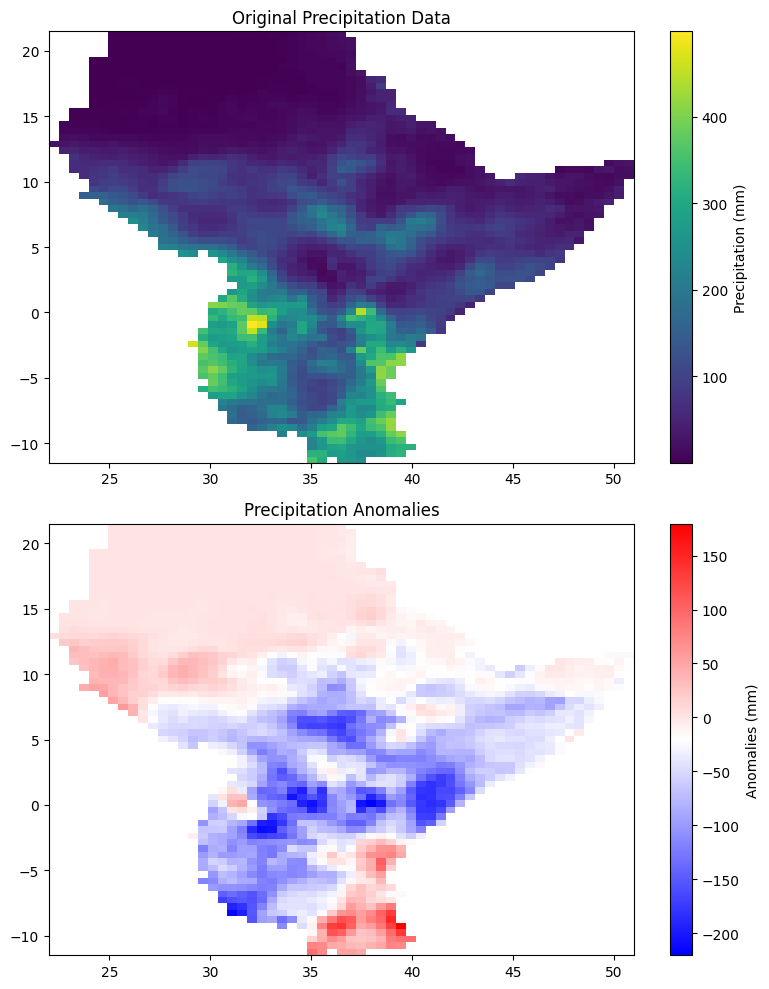

In [7]:
validate_anomalies1(prec_data, anomalies, lat, lon)

Visualize and compare original and transformed precipitation anomalies for a single year.


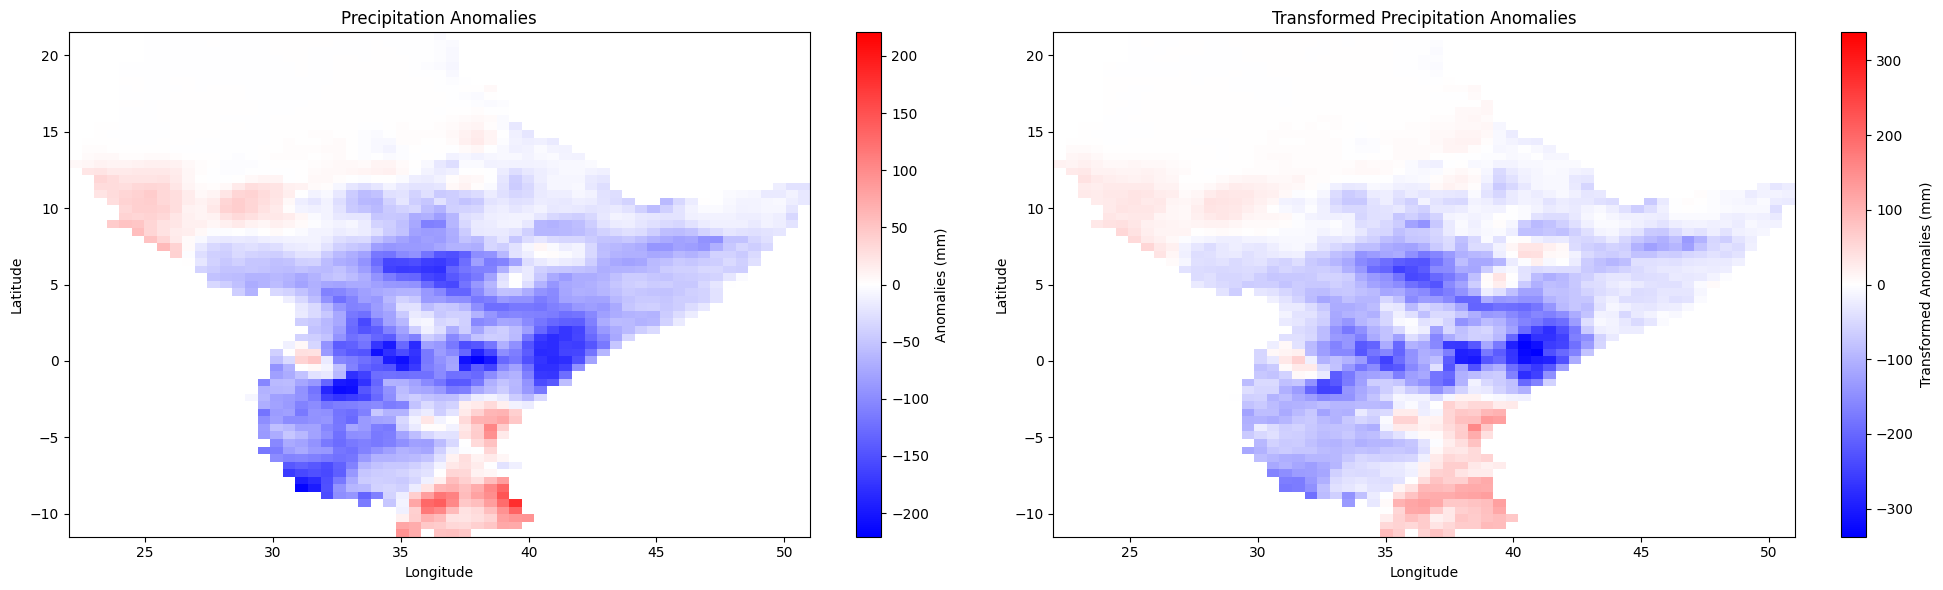

In [8]:
validate_anomalies2(anomalies, anomalies_normal, lat, lon)

Visualize and compare the distribution of original and transformed precipitation anomalies using histograms.


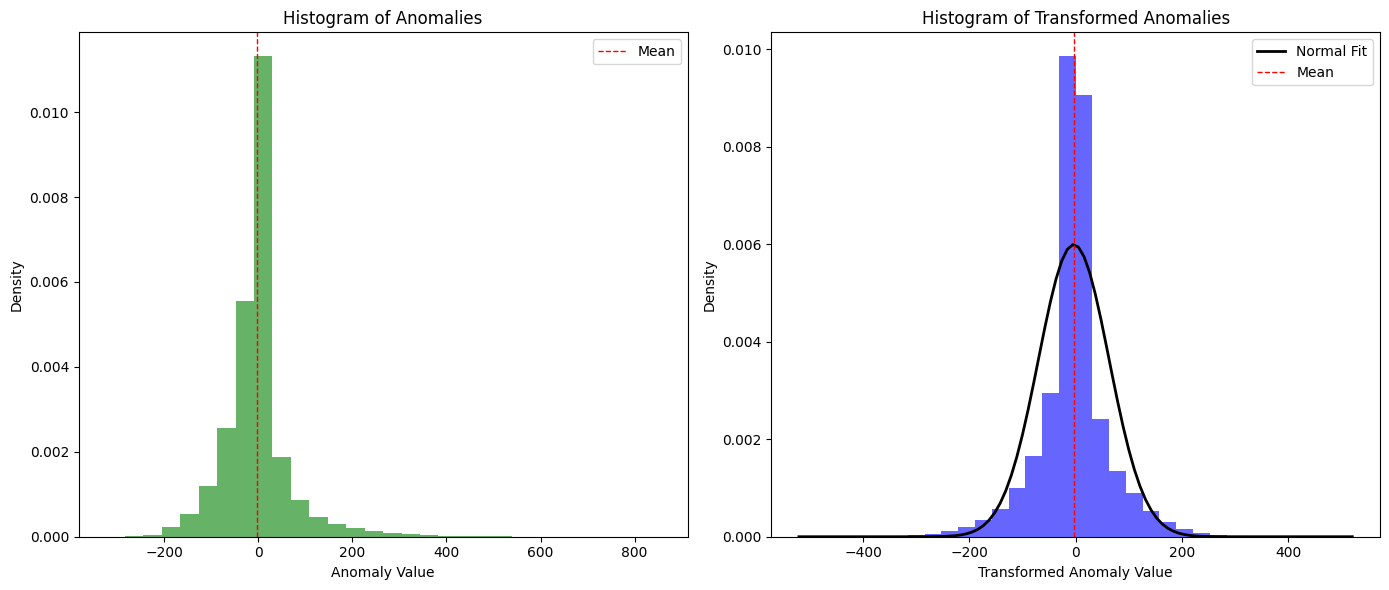

In [9]:
validate_anomalies3(anomalies, anomalies_normal)

In [10]:
validate_anomalies4(anomalies, anomalies_normal)

Printing some information about anomalies.
Anomalies - mean: -3.7547226 std: 70.41291
Transformed Anomalies - mean: -3.5514133 std: 66.5902
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 76200
NaN values in transformed anomalies: 76200


##### Get/calculate EOFs and factor loadings

In [11]:
# Get EOFs
if not path.exists(f'{val_dir}chirps_eofs.nc'):
    # Calculate EOFs
    n_eofs = 7  # Number of EOFs to compute
    eofs, pcs, var_fracs = compute_eofs_pcs(anomalies_normal, n_eofs)
    # Reshape EOFs to 3D (n_eofs, lat, lon)
    eofs_reshaped = eofs.reshape((n_eofs, len(lat), len(lon)))
    # Save EOFs, PCs and variance fractions
    save_eofs_pcs(eofs_reshaped, pcs, var_fracs, year, lat, lon, val_dir, n_eofs)
else:
    eofs_reshaped = xr.open_dataarray(f'{val_dir}chirps_eofs.nc', engine='netcdf4').values
    pcs = xr.open_dataarray(f'{val_dir}chirps_pcs.nc', engine='netcdf4').values
    var_fracs = xr.open_dataarray(f'{val_dir}chirps_var_fracs.nc', engine='netcdf4').values
    
print("Normalized Anomalies EOFs Shape:", eofs_reshaped.shape)
print("Normalized Anomalies PCs Shape:", pcs.shape)
print("Normalized Anomalies Variance Fraction:", var_fracs, "sum: ", var_fracs.sum())

Normalized Anomalies EOFs Shape: (7, 67, 59)
Normalized Anomalies PCs Shape: (40, 7)
Normalized Anomalies Variance Fraction: [0.5829194  0.08871375 0.06473098 0.0403941  0.02757974 0.02055769
 0.01733072] sum:  0.84222645


##### Plots to ensure calculating EOFs and factor loadings went well

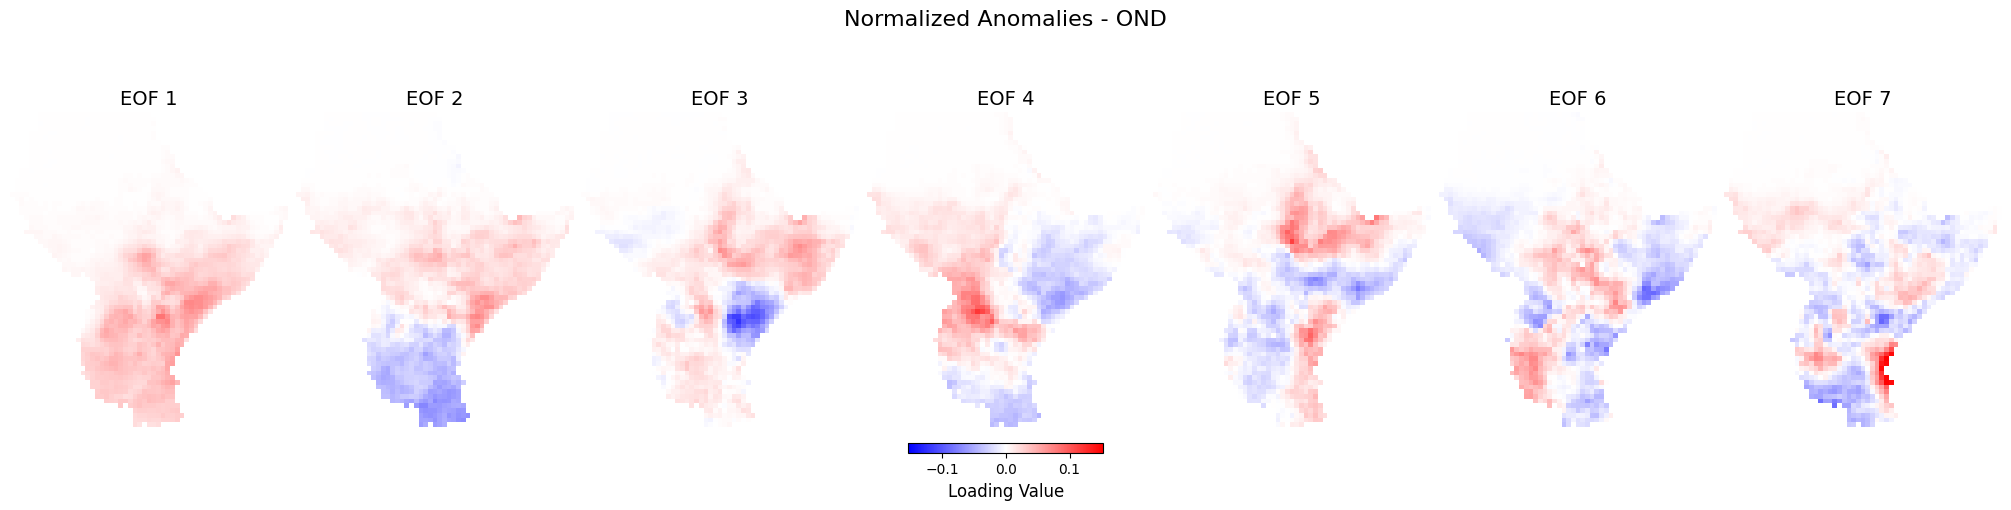

In [12]:
# Plot EOFs for normalized anomalies
validate_eofs(eofs_reshaped, f"Normalized Anomalies - {season}", n_eofs=7)

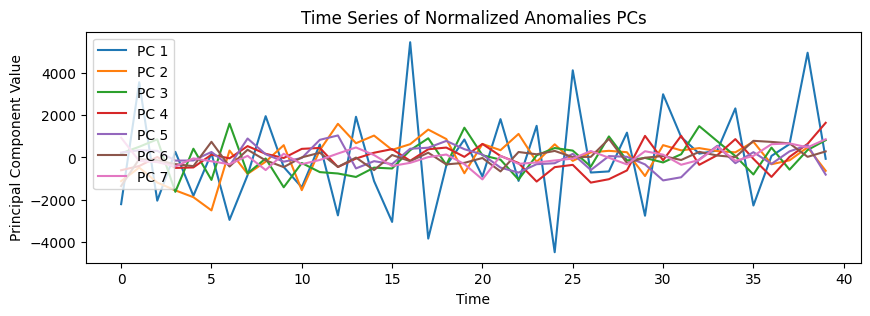

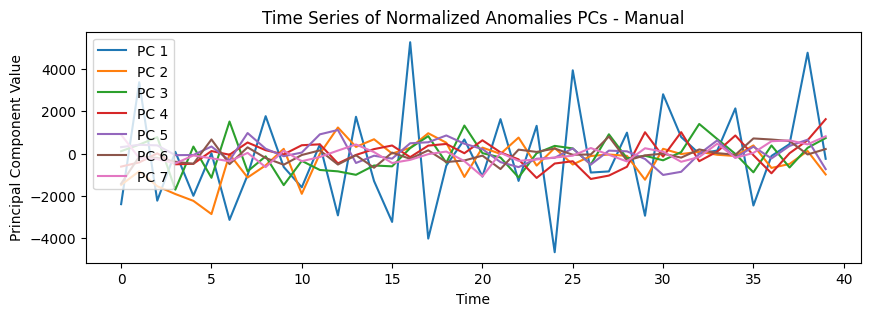

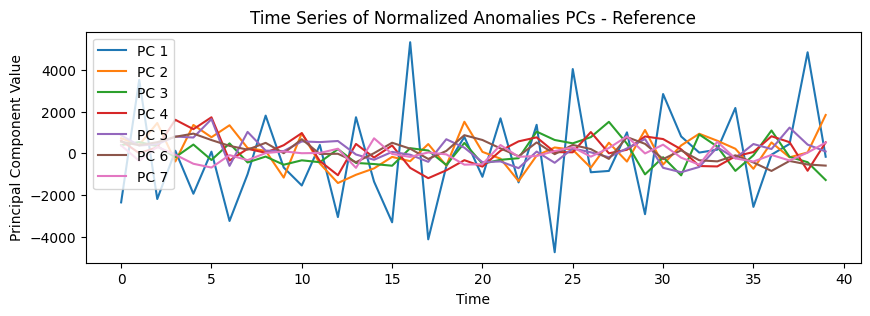

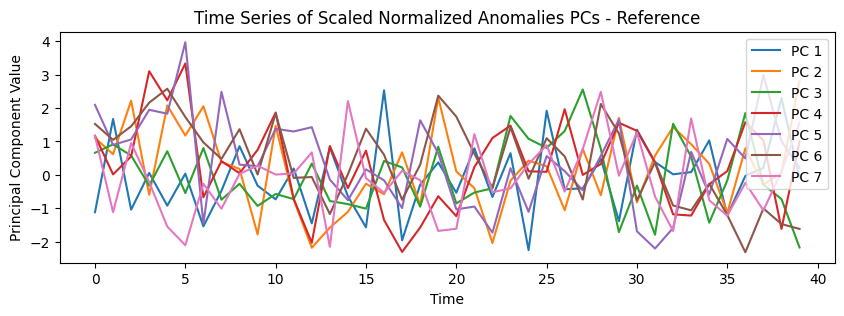

In [13]:
validate_pcs(anomalies_normal, eofs_reshaped, pcs, lat, lon, year, period_train, season, n_eofs = 7)

### ERA5 Data

If not already available, load ERA5 data, calculate indices, and save out. Otherwise, load ERA5 data.

##### Loading data

In [14]:
load_years = [*range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]

In [15]:
# Load sst data
sst_data = load_raw_data(era5_dir, "sst", load_years, season)
sst_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [16]:
# Load uwind200 data
uwind200_data = load_raw_data(era5_dir, "uwind200", load_years, season)
uwind200_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [17]:
# Load uwind850 data
uwind850_data = load_raw_data(era5_dir, "uwind850", load_years, season)
uwind850_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

##### Get/calculate indices

In [18]:
# Get era5 indices
# Define the file path
era5_indices_path = f'{val_dir}era5_indices.nc'
# Shared between all indices
months = list(range(1, 13))

if not path.exists(era5_indices_path):
    era5_indices = get_all_indices(sst_data, uwind200_data, uwind850_data, period_clm, period_train, months)
    # Save indices
    # Convert DataFrame to xarray Dataset for saving
    ds = era5_indices.set_index(['year', 'month']).to_xarray()

    # Save the Dataset to a NetCDF file
    print("Saving indices...")
    ds.to_netcdf(era5_indices_path)
    print(f"Data saved to {era5_indices_path}")

    # Print the first few rows of the DataFrame to verify
    print(era5_indices.head)
else:
    # Load the NetCDF file into an xarray Dataset
    ds_loaded = xr.open_dataset(era5_indices_path, engine='netcdf4')
    print(f"Data loaded from {era5_indices_path}")

    # Convert the xarray Dataset back to a DataFrame
    era5_indices = ds_loaded.to_dataframe().reset_index()

    # Print the first few rows of the DataFrame to verify
    print(era5_indices.head)

Data loaded from /nr/samba/user/ahellevik/CONFER-WP3/validation_data/era5_indices.nc
<bound method NDFrame.head of      year  month       n34        n3        n4       dmi  n34_diff1  \
0    1981      1 -0.878076 -1.105121 -0.610689  0.347750  -0.310888   
1    1981      2 -1.194670 -1.445646 -0.814860 -0.049903  -0.310888   
2    1981      3 -1.183618 -1.445331 -0.922555 -0.561697   0.010853   
3    1981      4 -1.678912 -1.919827 -0.753611  0.522551  -0.486369   
4    1981      5 -1.349333 -1.029916 -0.773688 -1.361840   0.323640   
..    ...    ...       ...       ...       ...       ...        ...   
475  2020      8 -0.769404 -0.739564 -0.778996 -0.922866  -0.345186   
476  2020      9 -1.014953 -1.199928 -0.985926 -0.770179  -0.241124   
477  2020     10 -1.263689 -1.201887 -1.209699  0.172647  -0.244254   
478  2020     11 -1.150069 -1.008953 -1.061598 -0.620625   0.111573   
479  2020     12 -0.849050 -0.660425 -1.115174 -0.103469   0.295595   

     dmi_diff1       wsp       w

##### Plots to ensure calculating indices went well

Validating index: dmi


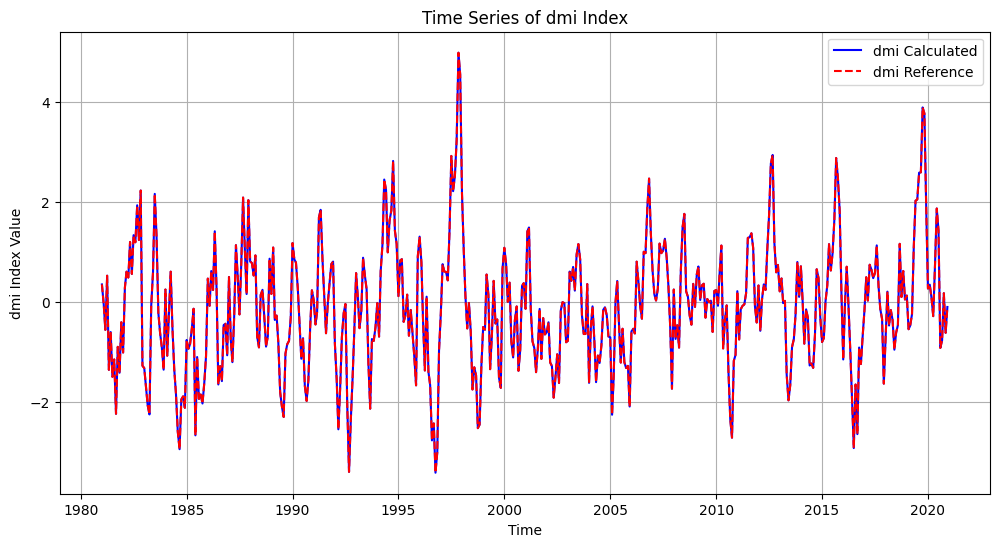

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 1.9419364929199219
Reference value: 1.9418332171625


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2652451992034912
Reference value: 0.265314241227996


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.3432576656341553
Reference value: 0.343302725351841


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.08859562873840332
Reference value: 0.0886621333093891


Validating index: dmi_diff1


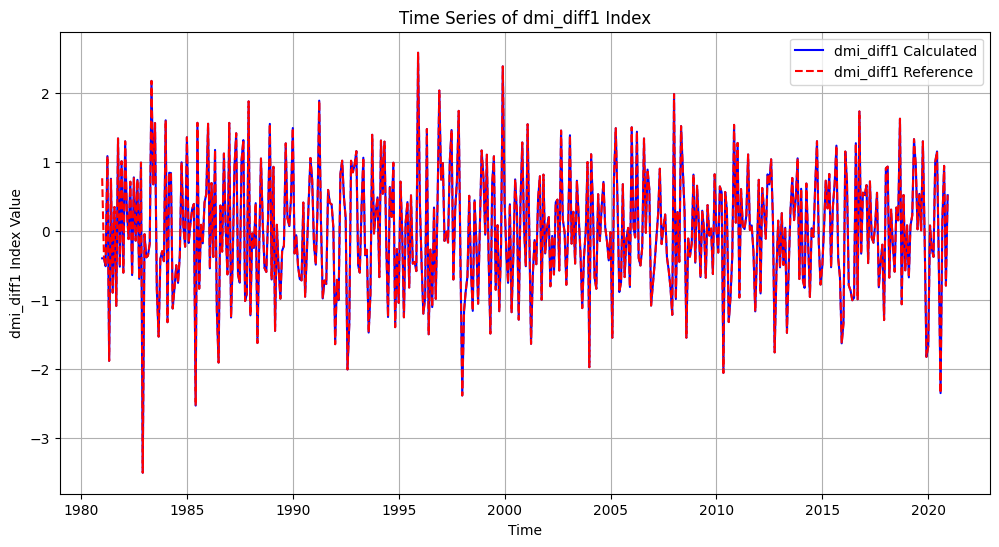

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.8267383575439453
Reference value: -1.82678177870107


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.6766912937164307
Reference value: -1.6765189759345


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.07801246643066406
Reference value: 0.0779884841238445


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.25466203689575195
Reference value: -0.254640592042452


Validating index: n3


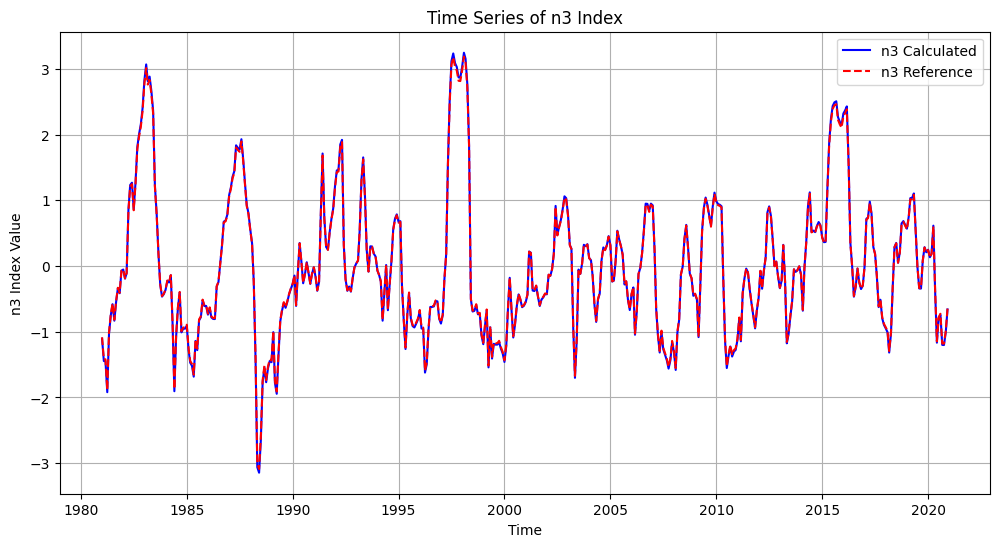

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.20983758568763733
Reference value: 0.206019603912169


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.2482137680053711
Reference value: 0.243756788163554


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.13393370807170868
Reference value: 0.13158023441094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.18719516694545746
Reference value: 0.183879605622572


Validating index: n34


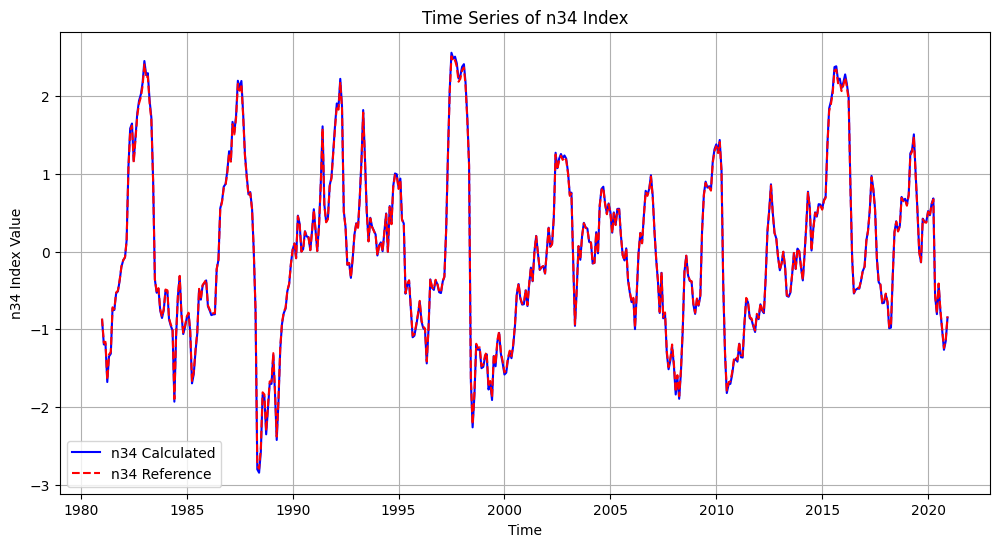

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.37987130880355835
Reference value: 0.372994201030477


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.522404134273529
Reference value: 0.513009703875565


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.4692562520503998
Reference value: 0.460850765524855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.6152685284614563
Reference value: 0.604228159008709


Validating index: n34_diff1


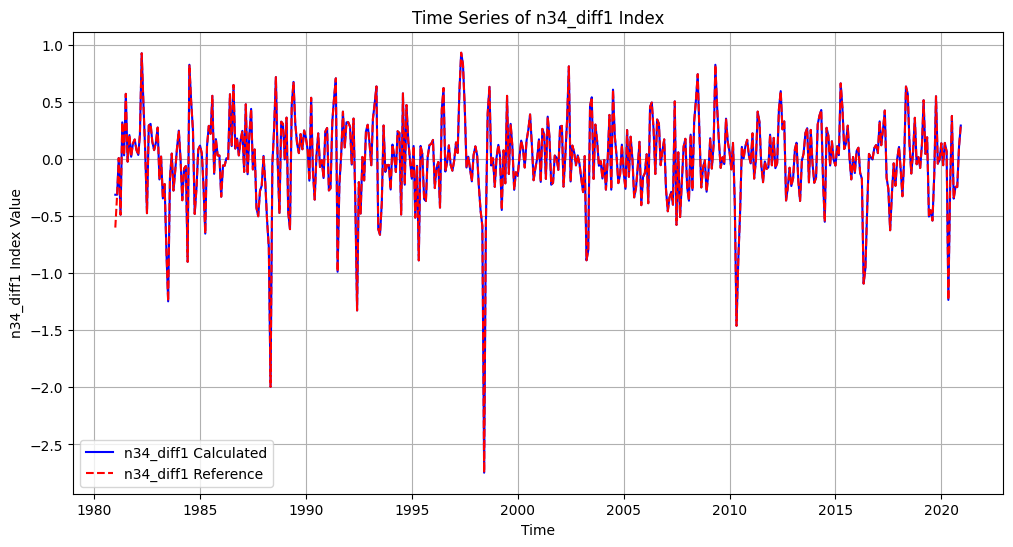

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.005655646324157715
Reference value: -0.0056419748808896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.1399645209312439
Reference value: 0.140015502845088


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.05219024419784546
Reference value: -0.0521589383507099


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.1433812379837036
Reference value: 0.143377393483854


Validating index: n4


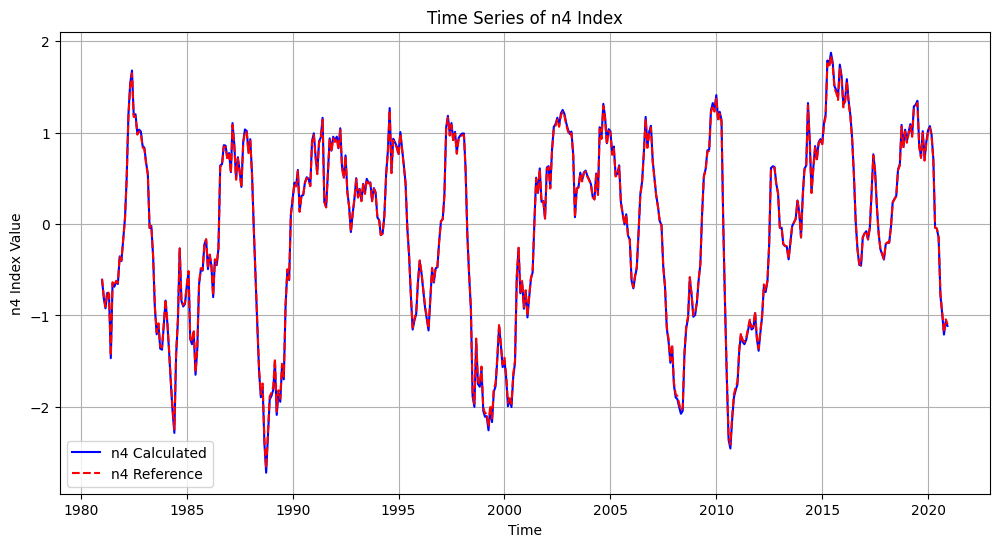

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8953214883804321
Reference value: 0.879144916265894


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.024899959564209
Reference value: 1.00643704571476


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 1.0707846879959106
Reference value: 1.05155372046276


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.9801605939865112
Reference value: 0.96257094914962


Validating index: sji200


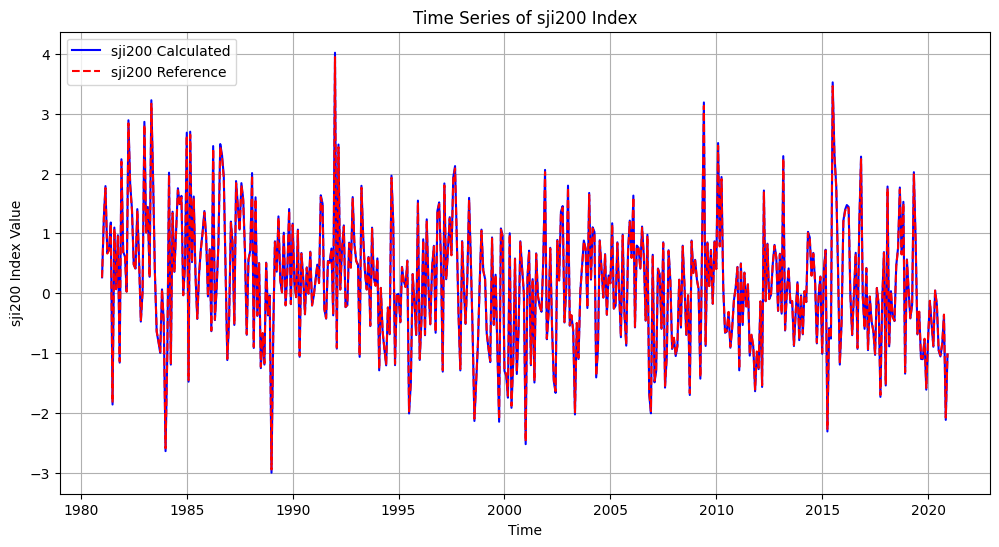

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.6115000247955322
Reference value: -1.58246167948365


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.7603710889816284
Reference value: -0.746669580627106


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -0.12836050987243652
Reference value: -0.126047556243128


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5111793875694275
Reference value: -0.501968169565544


Validating index: sji850


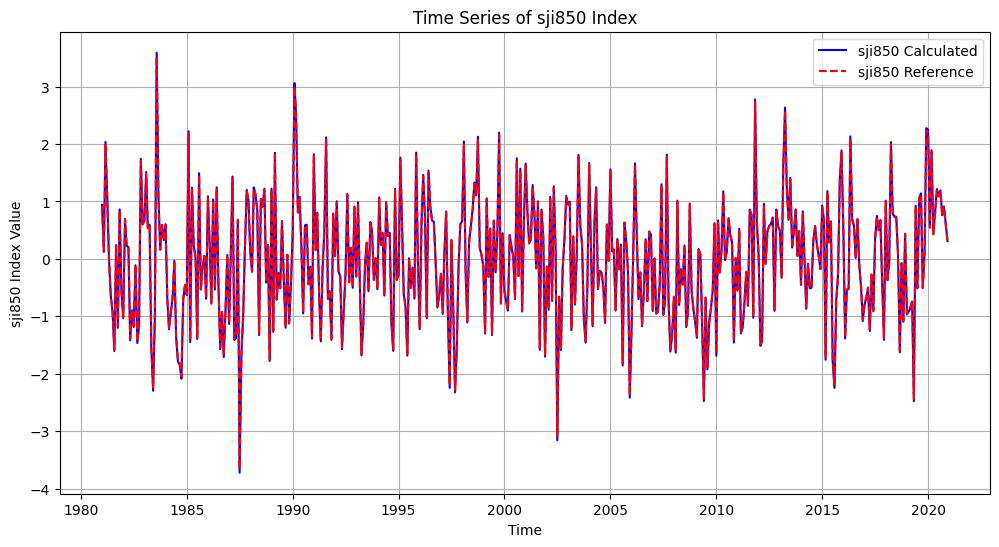

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 2.2761528491973877
Reference value: 2.23513716972386


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 2.2494091987609863
Reference value: 2.20887629889085


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.5522845387458801
Reference value: 0.542333684632671


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.8918044567108154
Reference value: 1.85771575568932


Validating index: ueq200


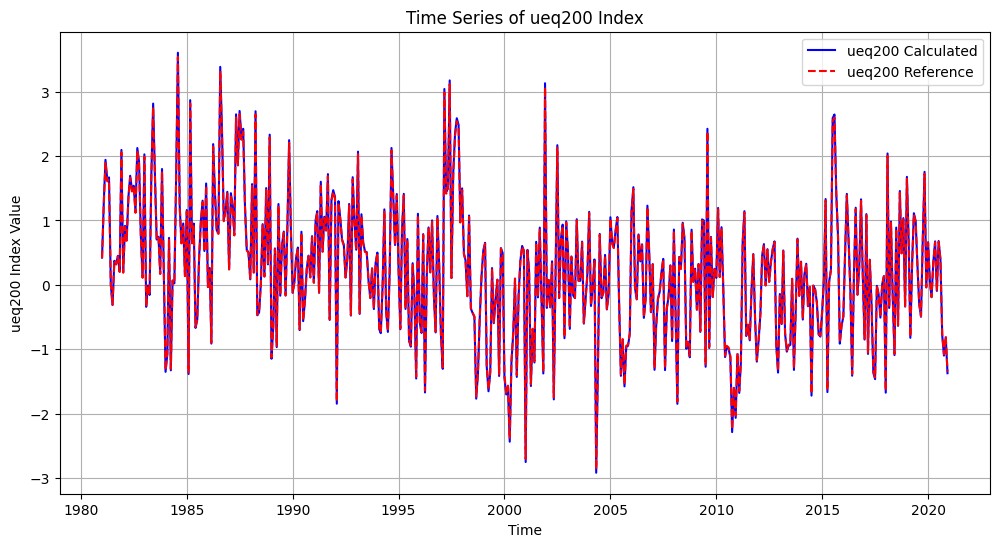

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -0.03881261497735977
Reference value: -0.0381129128773105


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6620338559150696
Reference value: 0.65010424548631


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.05884569510817528
Reference value: 0.0577853047959282


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.19194722175598145
Reference value: -0.188488269519044


Validating index: ueq850


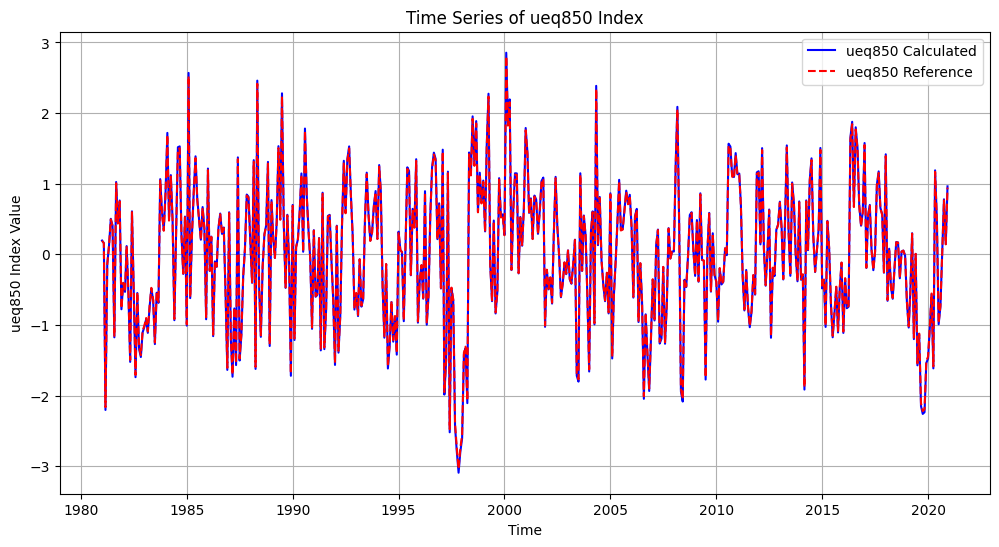

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: -1.5403413772583008
Reference value: -1.51258507670805


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -1.473352313041687
Reference value: -1.44680336146896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: -1.0252622365951538
Reference value: -1.0067874838614


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.5642094612121582
Reference value: -0.554042589497677


Validating index: wnp


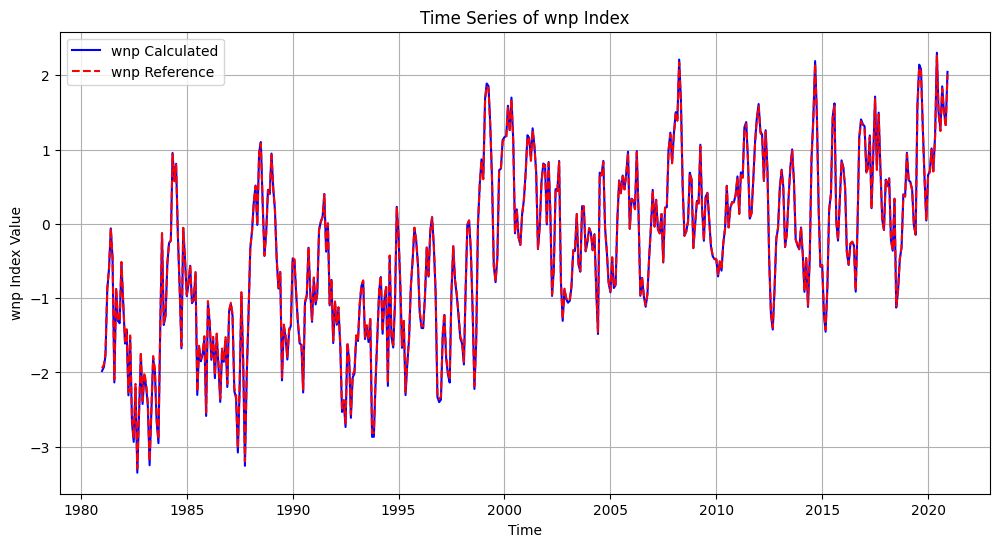

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.044872310012578964
Reference value: 0.0439991073142581


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.653798520565033
Reference value: 0.642058242147582


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.7116570472717285
Reference value: 0.698954206422623


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0151039361953735
Reference value: 0.99688132465


Validating index: wp


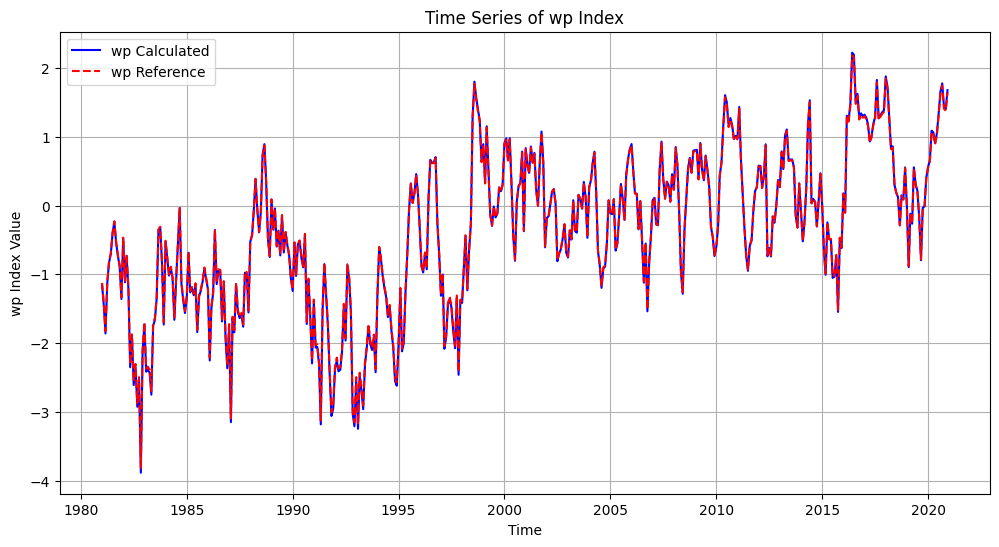

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.4036230146884918
Reference value: 0.3965014406094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.5627392530441284
Reference value: 0.552468608350522


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6579357385635376
Reference value: 0.645874754009963


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.0894144773483276
Reference value: 1.06964466368143


Validating index: wpg


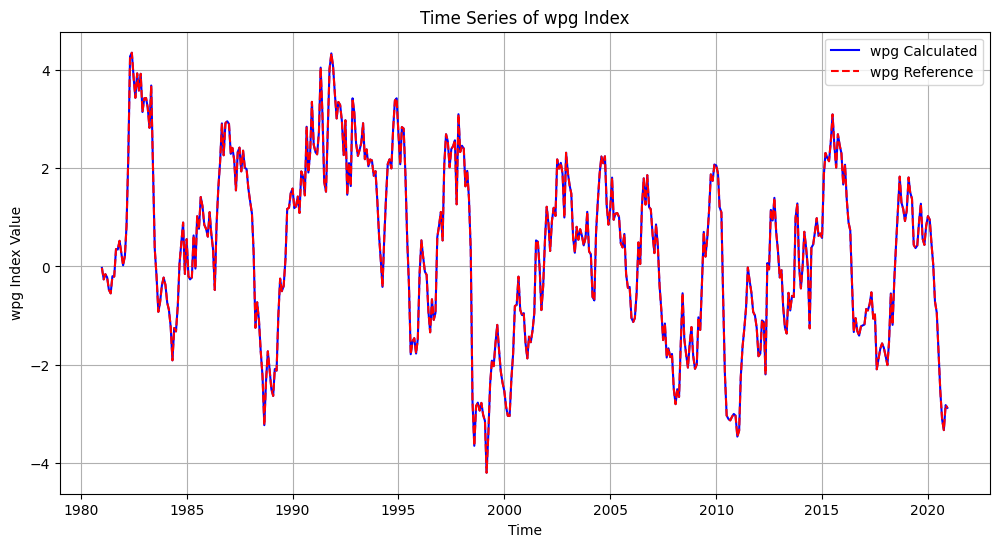

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.8253048062324524
Reference value: 0.8253758807116


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 1.0249437093734741
Reference value: 1.02486499573251


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.952954888343811
Reference value: 0.952911481535054


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 0.48157668113708496
Reference value: 0.481602647259719


Validating index: wsp


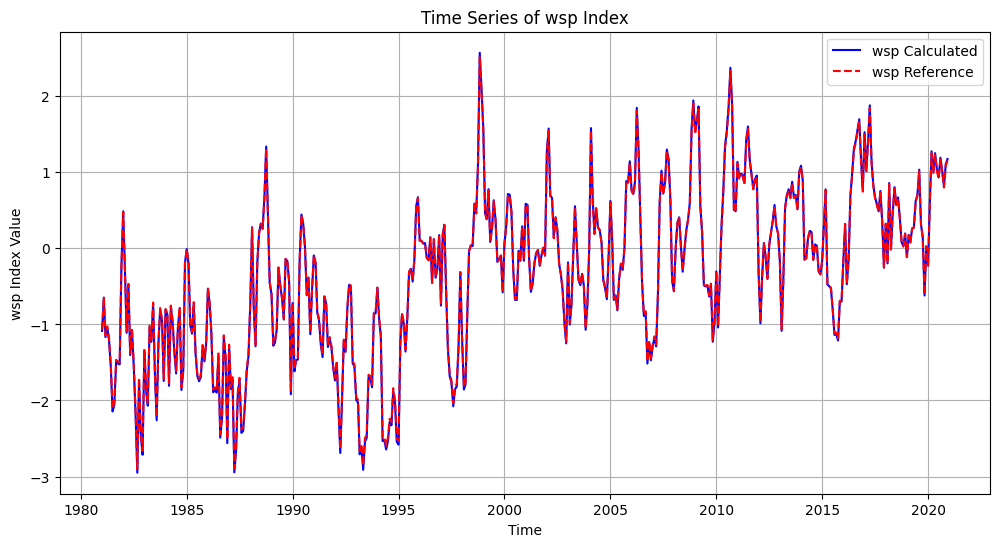

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.026800455525517464
Reference value: 0.0263166023317855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: -0.2280745953321457
Reference value: -0.223977062664927


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.6117443442344666
Reference value: 0.600790106588463


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: 1.2746162414550781
Reference value: 1.25162967063952


Validating index: wvg


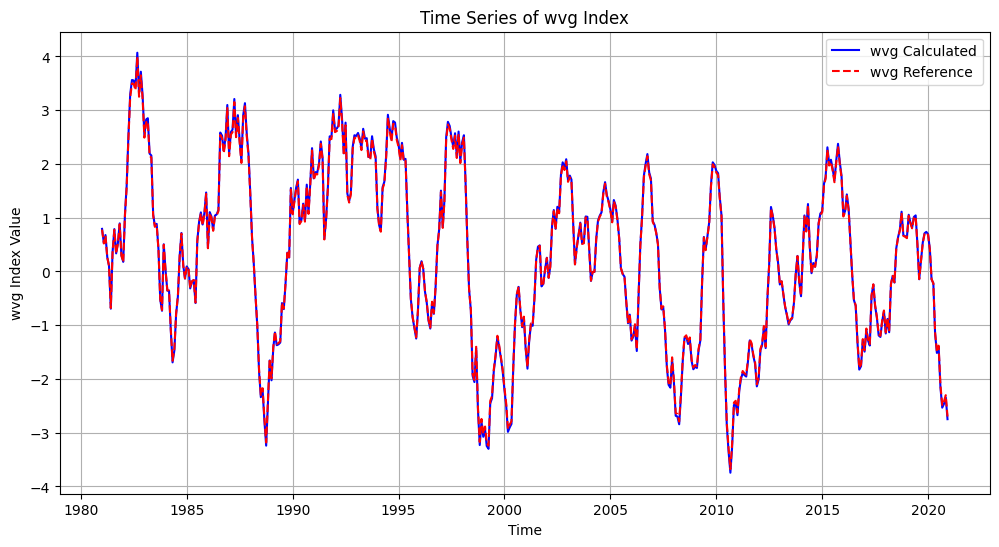

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
Calculated value: 0.7368895610173544
Reference value: 0.72353919951408


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
Calculated value: 0.6954122583071392
Reference value: 0.682920449770368


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
Calculated value: 0.41033899784088135
Reference value: 0.403014031455744


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
Calculated value: -0.14621762434641528
Reference value: -0.14348093717403




In [19]:
# Plot time series of each index comparing with reference, and print some numbers for verification
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'
validate_indices(era5_indices, filepath_indices, period_train, year_fcst)

### ML model

In [20]:
# Precip data:
# eofs_norm_anomalies_reshaped, numpy array of shape (eof = n_eofs, lat = 67, lon = 59) 
# pcs_ano_normal, numpy array of shape (year = train_end - train_start, n_eofs)
# var_frac_ano_normal, numpy array of shape (n_eofs, )
# Features/predictors: (dataframe with shape (year, month, standardized_anomaly))
# time_series_{feature}_df for feature in ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

feature_names = ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']
ntg = 7  # Number of EOFs

In [21]:
# Cross-validation setup
years_cv = list(range(year_train_start, year_train_end+1))
years_verif = list(range(year_clm_start, year_clm_end+1))
df_year = pd.DataFrame((np.array(years_cv) - 2000) / 10, index=years_cv, columns=['year'])

# Calculate explained variance
frac_expl_var = var_fracs / np.sum(var_fracs)
wgt_values = np.sqrt(frac_expl_var)
wgt = pd.DataFrame(np.tile(wgt_values, (len(years_verif), 1)), index=years_verif, columns=[f'eof{i+1}' for i in range(ntg)])

# Cross-validation folds
k = 5
nyr = len(years_cv)
cv_folds = []
for i in range(k):
    idx_test = set(range(i*2, nyr, k*2)).union(set(range(1+i*2, nyr, k*2)))
    idx_train = set(range(nyr)) - idx_test
    cv_folds.append((list(idx_train), list(idx_test)))

# DataFrames for storing results
df_fl_pred_mean = pd.DataFrame(index=years_verif, columns=[f'fl{i}' for i in range(1, ntg+1)])
df_fl_pred_cov = pd.DataFrame(index=years_verif, columns=[f'cov-{i}{j}' for i in range(1, ntg+1) for j in range(1, ntg+1)])
df_hyperparameters = pd.DataFrame(index=years_verif, columns=['alpha', 'l1_ratio'])
df_selected_features = pd.DataFrame(index=years_verif, columns=['year'] + feature_names, dtype=int)

In [49]:
# Fit models and make predictions
previous_month = month_init - 1 if month_init > 1 else 12

for iyr in years_verif:
    df_target = pd.DataFrame(pcs[:, :ntg], index=years_cv).reindex(years_cv)
    
    # Select the data for the month before month_init
    df_combined_features = era5_indices[(era5_indices['year'].isin(years_cv)) & (era5_indices['month'] == previous_month)].set_index('year')[feature_names]

    # Ensure there are no missing values
    df_combined_features.fillna(0, inplace=True)

    y = df_target.to_numpy()
    X = df_combined_features.to_numpy()

    # Feature pre-selection
    feature_idx = [True] + [False] * len(df_combined_features.columns)
    for ift in range(len(feature_idx) - 1):
        pval = [pearsonr(y[:, ipc], X[:, ift])[1] for ipc in range(ntg)]
        feature_idx[1 + ift] = np.any(np.array(pval) < 0.1 * wgt.iloc[0, :])

    df_combined_features = df_combined_features.iloc[:, feature_idx[1:]]
    df_year = pd.DataFrame((df_combined_features.index - 2000) / 10, index=df_combined_features.index, columns=['year'])
    selected_columns = ['year'] + df_combined_features.columns.to_list()

    # # Ensure df_selected_features has the correct columns
    if not set(selected_columns).issubset(df_selected_features.columns):
        for col in selected_columns:
            if col not in df_selected_features.columns:
                df_selected_features[col] = 0

    print(f'{iyr}: {sum(feature_idx)} features selected')
    if sum(feature_idx) == 1:
        df_combined_features = df_year
    else:
        df_combined_features = pd.concat([df_year, df_combined_features], axis=1)

    X = df_combined_features.to_numpy()
    # Lasso regression
    clf = MultiTaskLassoCV(cv=cv_folds, fit_intercept=False, max_iter=5000)
    clf.fit(X, y)
    df_hyperparameters.loc[iyr, 'alpha'] = clf.alpha_
    df_hyperparameters.loc[iyr, 'l1_ratio'] = 1.0
    ind_active = np.all(clf.coef_ != 0, axis=0)
    #print(ind_active)
    n_a = sum(ind_active)
    #print(n_a)
    if n_a > 0:
        #active_features = np.where(np.insert(ind_active, 0, True), 1, 0)  # Insert True for 'year' column
        active_features = np.where(ind_active, 1, 0)
        # Adjust the length of active_features to match selected_columns
        if len(active_features) != len(selected_columns):
            if len(active_features) < len(selected_columns):
                active_features = np.append(active_features, [0] * (len(selected_columns) - len(active_features)))
            else:
                active_features = active_features[:len(selected_columns)]
        
        df_selected_features.loc[iyr, selected_columns] = active_features
        dgf = 1 + n_a
    else:
        dgf = 1
    df_coefficients = pd.DataFrame(clf.coef_, index=[f'eof{i}' for i in range(1,ntg+1)], columns=df_combined_features.columns)
    #print(df_coefficients)
    # Compute prediction covariance
    errors = y - clf.predict(X)
    df_fl_pred_cov.loc[iyr, :] = np.broadcast_to((np.dot(errors.T, errors) / (nyr - dgf)).flatten(), (1, ntg ** 2))

#print(df_fl_pred_cov)
# Save results
# df_coefficients.to_csv(f'path_to_coefficients.csv')
# df_fl_pred_cov.to_csv(f'path_to_fl_pred_cov.csv')

1993: 10 features selected
1994: 10 features selected
1995: 10 features selected
1996: 10 features selected
1997: 10 features selected
1998: 10 features selected
1999: 10 features selected
2000: 10 features selected
2001: 10 features selected
2002: 10 features selected
2003: 10 features selected
2004: 10 features selected
2005: 10 features selected
2006: 10 features selected
2007: 10 features selected
2008: 10 features selected
2009: 10 features selected
2010: 10 features selected
2011: 10 features selected
2012: 10 features selected
2013: 10 features selected
2014: 10 features selected
2015: 10 features selected
2016: 10 features selected
2017: 10 features selected
2018: 10 features selected
2019: 10 features selected
2020: 10 features selected


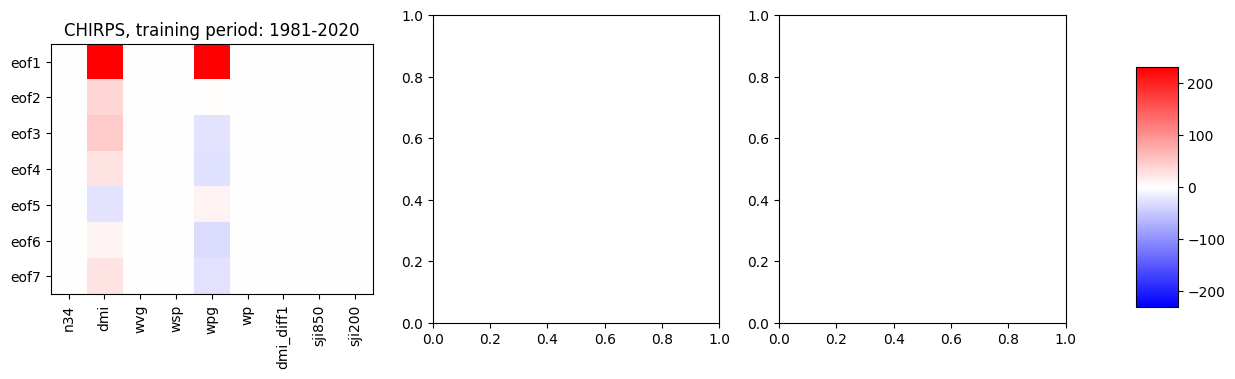

In [50]:
# Plot 1: CHIRPS vs. GPCC (short) vs. GPCC (long)

month = 8
season = 'OND'

month_str = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}[month]

fig, ax = plt.subplots(1,3, figsize=(14,4), width_ratios=[9, 8, 8])
for i, target_prod, cv_period in zip([*range(3)],['chirps'],['1981-2020']):
    df_coefficients = df_coefficients
    nft = len(df_coefficients.columns)
    ntg = len(df_coefficients.index)
    img = ax[i].imshow(df_coefficients, vmin={'MAM':-80., 'JJAS':-160., 'OND':-230.}[season], vmax={'MAM':80., 'JJAS':160., 'OND':230.}[season], cmap='bwr', extent=[0,nft,0,ntg])
    ax[i].set_xticks(np.arange(.5,nft))
    ax[i].set_xticklabels(df_coefficients.columns.to_list(), rotation=90, fontsize=10)
    ax[i].set_yticks(np.arange(ntg-.5,0,-1))
    ax[i].set_yticklabels(df_coefficients.index.to_list(), fontsize=10)
    ax[i].set_title(f'{target_prod.upper()}, training period: {cv_period}')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.6])
fig.colorbar(img, cax=cbar_ax)
#fig.suptitle(f'LASSO regression coefficients for {season} forecast issued in {month_str}', fontsize=14)

#plt.savefig(f'{data_dir}plots_ml_diagnostics/coef_training_period_comparison_im{month}_{season}.png')

In [51]:
def calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_clm, scaling, eofs, eigenvalues, coefficients, fl_eof_cov, ts_indices):

    # Ensure columns and indices alignment
    if not all(coefficients.columns == ts_indices.index):
        raise ValueError("Columns of coefficients and indices of ts_indices are not aligned.")
    
    # Calculate residual variance
    var_eps = scaling**2 - np.sum(eigenvalues[:, None, None] * eofs**2, axis=0)

    # Ensure ts_indices has year standardized
    ts_indices['year'] = (year_fcst - 2000) / 10

    # Calculate predictive mean of factor loadings
    fl_eof_mean = coefficients.dot(ts_indices).to_numpy()

    # Calculate mean and variance of the probabilistic forecast in normal space
    mean_ml = np.sum(fl_eof_mean[:, None, None] * eofs, axis=0)
    var_ml = np.sum(np.sum(fl_eof_cov[:, :, None, None] * eofs[None, :, :, :], axis=1) * eofs, axis=0) + var_eps

    mean_ml = np.array(mean_ml, dtype=np.float64)
    var_ml = np.array(var_ml, dtype=np.float64)

    mean_ml_stdz = mean_ml / scaling
    stdv_ml_stdz = np.sqrt(var_ml) / scaling

    # Calculate tercile forecasts
    prob_bn = norm.cdf((norm.ppf(0.333) - mean_ml_stdz) / stdv_ml_stdz)
    prob_an = 1.0 - norm.cdf((norm.ppf(0.667) - mean_ml_stdz) / stdv_ml_stdz)

    return prob_bn, prob_an

In [52]:
def plot_simple(fields, titles, cmap, unit, year):
    n_fields = len(fields)
    fig, axes = plt.subplots(1, n_fields, figsize=(15, 5), subplot_kw={'projection': None})

    for i, ax in enumerate(axes):
        im = ax.imshow(fields[i], extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                       origin='lower', cmap=cmap[i], vmin=0.333, vmax=1)
        ax.set_title(titles[i])
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')
        cbar.set_label(unit)

    fig.suptitle(f'Predicted tercile probabilities for {season} precipitation amounts, {year}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [53]:
def calculate_percentiles(chirps_data, ref_period_indices):
    # Extract the reference period indice
    chirps_ref = chirps_data[ref_period_indices, :, :]
    
    # Calculate the 33rd and 67th percentiles for each grid point
    percentile_33 = np.nanpercentile(chirps_ref, 33, axis=0)
    percentile_67 = np.nanpercentile(chirps_ref, 67, axis=0)
    
    return percentile_33, percentile_67


In [54]:
def categorize_precipitation(chirps_data, percentiles_33, percentiles_67, year):
    # Select the specific year
    actual_precip = chirps_data[year - year_train_start, :, :]
    
    # Categorize the precipitation
    below_normal = actual_precip < percentiles_33
    above_normal = actual_precip > percentiles_67
    normal = (actual_precip >= percentiles_33) & (actual_precip <= percentiles_67)
    
    # Create a categorical array: 0 for below normal, 1 for normal, 2 for above normal
    categories = xr.where(below_normal, 0, xr.where(above_normal, 2, 1))
    
    return categories

In [55]:
def verify_predictions(prob_bn, prob_an, actual_categories):
    # Determine the predicted category based on highest probability
    pred_categories = xr.where(prob_bn > 0.4, 0, xr.where(prob_an > 0.4, 2, 1))
    
    # Compare predictions with actual categories
    correct_predictions = pred_categories == actual_categories
    
    return correct_predictions

In [56]:
def plot_verification(verification, prec_data, lon, lat):
    # Reintroduce NaNs based on the original prec_data
    masked_verification = np.ma.masked_where(np.isnan(prec_data[year_fcst - year_train_start, :, :]), verification)
    
    # Create a custom colormap
    cmap = mcolors.ListedColormap(['red', 'green', 'gray'])
    bounds = [0, 0.5, 1.5, 2]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': None})
    
    im = ax.imshow(masked_verification, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                   origin='lower', cmap=cmap, norm=norm)
    
    ax.set_title(f'Verification of {season} {year_fcst} Precipitation Forecast')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Create a color bar with the correct labels
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', ticks=[0.25, 1, 1.75])
    cbar.ax.set_yticklabels(['Incorrect', 'Correct', 'Masked'])

    plt.tight_layout()
    plt.show()


In [57]:
simplefilter("ignore", category=RuntimeWarning)
# Select the reference period using a boolean mask
ref_period_mask = (year >= period_clm[0]) & (year <= period_clm[1])
ref_period_indices = np.where(ref_period_mask)[0]
# Season, year_fcst, month_init, period_train, period_clm, ntg predefined
# Model coeffiecients in df_coefficients
# previous_month = month_init - 1 if month_init > 1 else 12
year_fcst = 2020
for year_fcst in range(year_clm_start, year_clm_end+1):
    # Reshape the covariance matrix for each year
    def reshape_covariance_matrix(cov_df, ntg):
        reshaped_cov = np.zeros((len(cov_df), ntg, ntg))
        for i, year in enumerate(cov_df.index):
            reshaped_cov[i] = cov_df.loc[year].values.reshape(ntg, ntg)
        return reshaped_cov

    df_fl_pred_cov_reshaped = reshape_covariance_matrix(df_fl_pred_cov, ntg)

    # Use the reshaped covariance matrix with the right year
    cov_matrix_for_year = df_fl_pred_cov_reshaped[years_verif.index(year_fcst)]

    scaling = np.nanstd(anomalies_normal[ref_period_indices, :, :], axis = 0, ddof = 1)

    # # Prepare ts_indices
    # ts_indices = pd.Series(index=df_coefficients.columns)
    # for feature in feature_names:
    #     df_feature = feature_dfs[feature]
    #     df_feature_selected = df_feature[df_feature['month'] == previous_month].set_index('year')['standardized_anomaly']
    #     ts_indices[feature] = df_feature_selected.loc[year_fcst]
    # Prepare ts_indices
    ts_indices = pd.Series(index=df_coefficients.columns)
    # Select the data for the forecast year and previous month
    year_month_mask = (era5_indices['year'] == year_fcst) & (era5_indices['month'] == previous_month)
    ts_indices = era5_indices.loc[year_month_mask, feature_names].iloc[0]

    eigenvalues = var_fracs  # The variance fraction for each EOF
    # Ensure alignment before using the function
    coefficients_columns = df_coefficients.columns.to_list()
    ts_indices = ts_indices.reindex(coefficients_columns)

    prob_bn, prob_an = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_clm, scaling, eofs_reshaped, eigenvalues, df_coefficients, cov_matrix_for_year, ts_indices)

    # Plot the probabilities
    plot_simple(fields=[prob_bn, prob_an],
                titles=['Below Normal', 'Above Normal'],
                cmap=['Oranges', 'Greens'],
                unit='Probability',
                year=year_fcst)

    # Define the reference period
    reference_period = period_clm

    # Calculate percentiles
    percentiles_33, percentiles_67 = calculate_percentiles(prec_data, ref_period_indices)

    actual_categories = categorize_precipitation(prec_data, percentiles_33, percentiles_67, year_fcst)
    verification = verify_predictions(prob_bn, prob_an, actual_categories)

    # Plot the verification
    plot_verification(verification, prec_data, lon, lat)


ValueError: matrices are not aligned

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from memory_profiler import profile

def get_nearest_grid_index(lon_exmpl, lat_exmpl, lon_grid, lat_grid):
    ix = np.argmin(abs(lon_grid-lon_exmpl))
    iy = np.argmin(abs(lat_grid-lat_exmpl))
    return ix, iy

def get_xticks(x_extent, inc = 1):
    x_inc = np.arange(-180,180,inc)
    return(x_inc[np.where(np.logical_and(x_inc >= x_extent[0], x_inc <= x_extent[1]))])

def get_yticks(y_extent, inc = 1):
    y_inc = np.arange(-90,90,inc)
    return(y_inc[np.where(np.logical_and(y_inc >= y_extent[0], y_inc <= y_extent[1]))])

@profile
def plot_fields(fields_list, lon, lat, lon_bounds, lat_bounds, main_title, subtitle_list, unit, vmin=None, vmax=None, cmap='BuPu', water_bodies=False, ticks=True, tick_labels=None):

    n_img = len(fields_list)
    img_extent = lon_bounds + lat_bounds

    if not type(unit) is list:
        unit = [unit for i in range(n_img)]

    if not type(cmap) is list:
        cmap = [cmap for i in range(n_img)]

    if vmin == None:
        vmin = [np.nanmin(field) for field in fields_list]
    if vmax == None:
        vmax = [np.nanmax(field) for field in fields_list]

    if not type(vmin) is list:
        vmin = [vmin for i in range(n_img)]
    if not type(vmax) is list:
        vmax = [vmax for i in range(n_img)]       

    if ticks == True:
        ticks = [ticks for i in range(n_img)]
    elif not type(ticks) is list:
        print("Error! Argument 'ticks' must be a list or a list of lists.")
    elif all([isinstance(tt, float) or isinstance(tt, int) for tt in ticks]):
        ticks = [ticks for i in range(n_img)]

    if tick_labels == None:
        tick_labels = [tick_labels for i in range(n_img)]
    elif not type(tick_labels) is list:
        print("Error! Argument 'ticks_labels' must be a list or a list of lists.")
    elif all([isinstance(tt, float) or isinstance(tt, int) or isinstance(tt, str) for tt in tick_labels]):
        tick_labels = [tick_labels for i in range(n_img)]

    r = abs(lon[1]-lon[0])
    lons_mat, lats_mat = np.meshgrid(lon, lat)
    lons_matplot = np.hstack((lons_mat - r/2, lons_mat[:,[-1]] + r/2))
    lons_matplot = np.vstack((lons_matplot, lons_matplot[[-1],:]))
    lats_matplot = np.hstack((lats_mat, lats_mat[:,[-1]]))
    lats_matplot = np.vstack((lats_matplot - r/2, lats_matplot[[-1],:] + r/2))     # assumes latitudes in ascending order

    dlon = (lon_bounds[1]-lon_bounds[0]) // 8
    dlat = (lat_bounds[1]-lat_bounds[0]) // 8

    fig_height = 7.
    fig_width = (n_img*1.15)*(fig_height/1.1)*np.diff(lon_bounds)[0]/np.diff(lat_bounds)[0]

    fig = plt.figure(figsize=(fig_width,fig_height))
    for i_img in range(n_img):
        ax = fig.add_subplot(100+n_img*10+i_img+1, projection=ccrs.PlateCarree())
        cmesh = ax.pcolormesh(lons_matplot, lats_matplot, fields_list[i_img], cmap=cmap[i_img], vmin=vmin[i_img], vmax=vmax[i_img])
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.set_yticks(get_yticks(img_extent[2:4],dlat), crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(LatitudeFormatter()) 
        ax.set_xticks(get_xticks(img_extent[0:2],dlon), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        ax.add_feature(cfeature.COASTLINE, linewidth=2)
        ax.add_feature(cfeature.BORDERS, linewidth=2, linestyle='-', alpha=.9)
        if water_bodies:
            ax.add_feature(cfeature.LAKES, alpha=0.95)
            ax.add_feature(cfeature.RIVERS)

        plt.title(subtitle_list[i_img], fontsize=14)
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
        fig.add_axes(ax_cb)
        cbar = plt.colorbar(cmesh, cax=ax_cb)
        cbar.set_label(unit[i_img])
        if not ticks[i_img] == True:
            cbar.set_ticks(ticks[i_img])
            cbar.set_ticklabels(tick_labels[i_img])

    fig.canvas.draw()
    plt.tight_layout(rect=[0,0,1,0.95])
    fig.suptitle(main_title, fontsize=16)
    plt.show()



In [ ]:
# plot_fields(fields_list = [prob_bn, prob_an],
#           lon = lon,
#           lat = lat,
#           lon_bounds = lon_bnds,
#           lat_bounds = lat_bnds,
#           main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
#           subtitle_list = ['below normal','above normal'],
#           vmin = 0.333,
#           vmax = 1,
#           cmap = ['Oranges','Greens'],
#           unit = '')

In [ ]:


#data_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/'

# month = month_init                # month in which the forecast is issued; predictors are taken from previous month
# season_name = season
# ref_period = f'{year_clm_start}-{year_clm_end}'


# print(f'\n Generating {season} forecasts at halfdeg resolution')

# # -- Calculate explained variance by the respective EOFs-----------------------------------------------------------------------------------------------------------------------

# refper_start = int(ref_period[:4])
# refper_end = int(ref_period[-4:])

# nc = xr.open_dataset(f'{data_dir}eofs/chirps/halfdeg_res/refper_{ref_period}/prec_loyo_seasonal_{season}.nc')
# nc_subset = nc.sel(loy=slice(years_verif[0],years_verif[-1]))
# eigenvalues = (nc_subset.d.values**2) / (refper_end-refper_start)
# nc.close()

# for iyr in years_verif:
# #    print(iyr)
#     df_target = data_prec.loc[(slice(None),iyr,range(1,ntg+1)),:].unstack().droplevel(level=1).droplevel(level=0, axis=1).fillna(0.).reindex(years_cv)
#     data_indices_yr = []
#     for i in range(len(data_indices)):
#         data_indices_yr.append(data_indices[i].loc[(slice(None),month-1,iyr),:].droplevel(level=(1,2)))
#     df_features = pd.concat(data_indices_yr, axis=1).fillna(0.).reindex(years_cv)
#     y = df_target.to_numpy()
#     X = df_features.to_numpy()
#    # Feature pre-selection
#     feature_idx = [True]+[False]*len(df_features.columns)
#     for ift in range(len(feature_idx)-1):
#         pval = [pearsonr(y[:,ipc], X[:,ift])[1] for ipc in range(ntg)]
#         feature_idx[1+ift] = np.any(np.array(pval)<0.1*wgt.loc[iyr])
#     df_features = df_features.iloc[:,feature_idx[1:]]
#     df_selected_features.loc[iyr,['year']+df_features.columns.to_list()] = 0
#     print(f'{iyr}: {sum(feature_idx)} features selected')
#    # Interactions with b/n/a dummy variables of features
#     if sum(feature_idx) == 1:
#         df_features = df_year
#     else:
#         df_features = pd.concat([df_year, df_features], axis=1)

#     X = df_features.to_numpy()

#     # Lasso regression of pre-selected features
#     clf = MultiTaskLassoCV(cv=cv_folds, fit_intercept=False, max_iter=5000)
#     clf.fit(X, y)
#     df_hyperparameters.loc[iyr,'alpha'] = clf.alpha_
#     df_hyperparameters.loc[iyr,'l1_ratio'] = 1.
#     ind_active = np.all(clf.coef_!=0, axis=0)
#     n_a = sum(ind_active)
#     if n_a > 0:
#         df_selected_features.loc[iyr,df_features.columns.to_list()] = np.where(ind_active, 1, 0)
#         dgf = 1 + n_a
#     else:
#         dgf = 1
#    # In 'full' mode, we mainly care about the estimated coefficients
#     df_coefficients = pd.DataFrame(clf.coef_, index=[f'eof{i}' for i in range(1,ntg+1)], columns=df_features.columns)
#     errors = y - clf.predict(X)
#     df_fl_pred_cov.loc[:,:] = np.broadcast_to((np.dot(errors.T,errors)/(nyr-dgf)).flatten(), (len(years_verif),ntg**2))
#     break


# # if not path.exists(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res'):
# #     os.mkdir(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res')

# # if not path.exists(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}'):
#     os.mkdir(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}')

# df_coefficients.to_csv(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/coefficients_{predictor}_lasso_full_im{month}_{season}.csv')
# df_fl_pred_cov.to_csv(f'{data_dir}fls_pred/chirps/seasonal/halfdeg_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/fls_cov_{predictor}_lasso_full_im{month}_{season}.csv')



Run LASSO model to predict precipitation EOFs based on indices.

In [ ]:
# do it

Visualize fitted coefficients

In [ ]:
# do it

Load indices for the forecast year and use the previously fitted model to make a forecast

In [ ]:
#prob_fcst_below, prob_fcst_above = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_train, period_clm, indices_dir, anomaly_dir, eof_dir, fcst_dir)

Depict as a map.

In [ ]:
# plot_fields (fields_list = [prob_fcst_below, prob_fcst_above],
#           lon = lon,
#           lat = lat,
#           lon_bounds = lon_bnds,
#           lat_bounds = lat_bnds,
#           main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
#           subtitle_list = ['below normal','above normal'],
#           vmin = 0.333,
#           vmax = 1,
#           cmap = ['Oranges','Greens'],
#           unit = '')